In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)


/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.96
Loading CCF brain structure data...
Loading time: 0.00


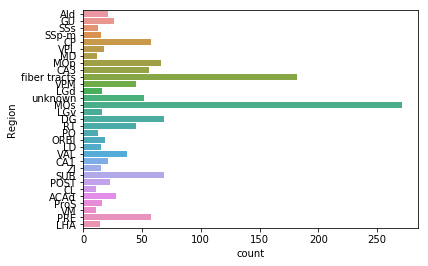

In [2]:
sf = ns.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )

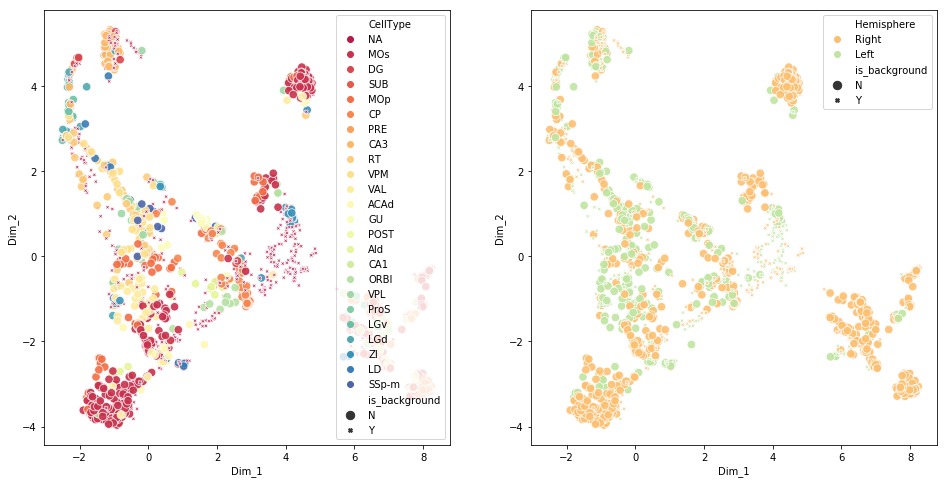

In [3]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)
_ = ns.FeatureScatter(["CellType", "Hemisphere"], map="UMAP")

### Generate the dataframe in pickCLUSTERpara(method)

In [4]:
import pickle
pickle_in = open("/home/penglab/NMTcode/selectedDF.pickle","rb")
[selectedDF] = pickle.load(pickle_in)


In [5]:
from sklearn import metrics
from random import randrange
def pickCLUSTERpara(method,selected_list):
    if len(selected_list) >0:
        print('Will calculate ARI for '+ str(len(selected_list) ) + ' neurons')
    result_DF = pd.DataFrame()
    method_list = ['kmeans','snn','hdbscan','hierarchy','dbscan']
    assert method in method_list, "Should be one of "+str(method_list)
    colname = ['ARI','NumCluster','parameter']
    if method.lower() == 'hierarchy':
        #%% Store the result of Hierarchy
        result_hier = pd.DataFrame(columns = colname)
        L_method_list=['single', 'complete','average','weighted','centroid','median','ward']
        L_metric_list=['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine',
                       'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 
                       'mahalanobis', 'matching','minkowski','rogerstanimoto', 'russellrao',
                       'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']

        criterionH_list=['inconsistent','distance','maxclust','monocrit','maxclust_monocrit']

        hier_dict={'L_method':'single', 'L_metric':'euclidean','criterionH':'inconsistent', 'depth':2,'R':None,
                   't':0.9,'optimal_ordering':False,'colR':3}
        for L_methodidx in L_method_list:
            hier_dict.update(L_method = L_methodidx)
            for L_metricidx in L_metric_list:
                hier_dict.update(L_metric = L_metricidx )
                # so far the parameter to generate the linkage array is set
                if L_methodidx == 'centroid' or L_methodidx == 'median' or L_methodidx == 'ward':
                    if L_metricidx != 'euclidean':
                        continue         
                for criterionidx in criterionH_list:
                    hier_dict.update(criterionH = criterionidx )   
                    if criterionidx == 'inconsistent' or criterionidx == 'distance':
                        for t_iter in  np.arange(0,1.6,0.05)  : 
                            hier_dict.update(t = t_iter) 
                            if criterionidx == 'inconsistent':
                                for depth_iter in range(2,16):
                                    hier_dict.update(depth = depth_iter) 
                                    _ = ns. get_clusters(method='Hierarchy',karg_dict=hier_dict)
                                    if len(selected_list)==0:
                                        selected_list = ns.metadata.index.tolist()
                                    tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                                    tempDF = pd.DataFrame([tempARI, 
                                                           len(list(ns.metadata.groupby('Cluster'))),
                                                           str(hier_dict)]).T.copy()
                                    tempDF.columns=colname
                                    print(str(hier_dict))
                                    result_hier = result_hier.append(tempDF) 
                            elif criterionidx == 'distance':
                                _ = ns. get_clusters(method='Hierarchy',karg_dict=hier_dict)
                                tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                                tempDF = pd.DataFrame([tempARI, 
                                                       len(list(ns.metadata.groupby('Cluster'))),
                                                       str(hier_dict)]).T.copy()
                                tempDF.columns=colname
                                print(str(hier_dict))
                                result_hier = result_hier.append(tempDF) 
                    if criterionidx == 'maxclust' or criterionidx == 'maxclust_monocrit':
                        for t_iter in  range(20,51): 
                            hier_dict.update(t = t_iter) 
                            _ = ns. get_clusters(method='Hierarchy',karg_dict=hier_dict)
                            tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                            tempDF = pd.DataFrame([tempARI, 
                                                   len(list(ns.metadata.groupby('Cluster'))),
                                                   str(hier_dict)]).T.copy()
                            tempDF.columns=colname
                            print(str(hier_dict))
                            result_hier = result_hier.append(tempDF) 
                               
        idx_hier = ['Hier'+str(x) for x in range(result_hier.shape[0])]    
        result_hier['idx'] = idx_hier
        result_hier.set_index('idx',inplace=True)  
        result_DF = result_hier.copy()
        
    if method.lower() == 'kmeans':
        result_kmeans = pd.DataFrame(columns = colname)
        init_list=['k-means++','random']
        algorithm_list = ['auto','full','elkan']
        precompute_distances_list = ['auto', True, False]
        n_init_list=['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine',
                       'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 
                       'mahalanobis', 'matching','minkowski','rogerstanimoto', 'russellrao',
                       'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
        criterionH_list='inconsistent','distance','maxclust','monocrit','maxclust_monocrit'
        kmeans_dict={'n_clusters':20, 'init':'k-means++', 'n_init':10, 'max_iter':300, 'tol':0.0001,
                     'precompute_distances':'auto', 'verbose':0, 'random_state':None,'copy_x': True,
                     'n_jobs':12, 'algorithm':'auto'}
        for init_idx in init_list:
            kmeans_dict.update(init = init_idx)
            for algorithm_idx in algorithm_list:
                kmeans_dict.update(algorithm = algorithm_idx )
                for precompute_distances_idx in precompute_distances_list:
                    kmeans_dict.update(precompute_distances = precompute_distances_idx )
                    for n_clustersidx in range(3,45):
                        kmeans_dict.update(n_clusters = n_clustersidx)     
                        for n_initidx in range(7,15):
                            kmeans_dict.update(n_init = n_initidx) 
                            for tol_idx in np.exp(-np.arange(2,4,0.2)):
                                kmeans_dict.update(tol = tol_idx) 
                                print(kmeans_dict)
                                _ = ns. get_clusters(method='Kmeans',karg_dict=kmeans_dict)
                                tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                                tempDF = pd.DataFrame([tempARI, 
                                                       len(list(ns.metadata.groupby('Cluster'))),
                                                       str(kmeans_dict)]).T.copy()
                                tempDF.columns=colname
                                print(str(kmeans_dict))
                                result_kmeans = result_kmeans.append(tempDF)         
        idx_kmeans = ['KMeans'+str(x) for x in range(result_kmeans.shape[0])]    
        result_kmeans['idx'] = idx_kmeans
        result_kmeans.set_index('idx',inplace=True)       
        result_DF = result_kmeans.copy()
        
    if method.lower() == 'dbscan':
        result_dbscan = pd.DataFrame(columns = colname)
        algorithm_list = ['auto','ball_tree', 'kd_tree', 'brute']# 
         #
        metriclist = [ 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation','euclidean', 'cosine',
                      'dice','hamming', 'jaccard', 'kulsinski', 'matching','minkowski','rogerstanimoto','russellrao','sokalmichener', 'sokalsneath']
        dbscan_dict={'eps':20, 'min_samples':5, 'metric':'euclidean','metric_params':None, 'algorithm':'auto', 
                     'leaf_size':30, 'p':None,'n_jobs':12}
        for algorithm_idx in algorithm_list:
            dbscan_dict.update(algorithm = algorithm_idx )
            for metric_iter in metriclist:
                dbscan_dict.update(metric= metric_iter)
                if algorithm_idx == 'ball_tree' and metric_iter in ['correlation','cosine','sqeuclidean']:
                    continue
                if algorithm_idx == 'kd_tree' and metric_iter not in ['chebyshev', 'cityblock', 'euclidean',
                                                                                   'infinity', 'l1', 'l2', 'manhattan',
                                                                                  'minkowski', 'p']:
                    continue
                if algorithm_idx == 'brute' and metric_iter in ['haversine','wminkowski', 'mahalanobis','infinity']:
                    continue
                if metric_iter in ['wminkowski', 'minkowski']:
                    p_iter =randrange(1,10)
                    dbscan_dict.update(p = p_iter)
                    while metric_iter == 'minkowski' and p_iter == 1:
                        p_iter =randrange(2,10)
                        dbscan_dict.update(p = p_iter)
                for epsidx in np.exp(-np.arange(0,4,0.5)):
                    dbscan_dict.update(eps = epsidx)
                    for min_samples_iter in range(5,10):
                        dbscan_dict.update(min_samples = min_samples_iter)
                        for leaf_size_iter in range(25,35):
                            dbscan_dict.update(leaf_size = leaf_size_iter)
                            _ = ns. get_clusters(method='DBSCAN',karg_dict=dbscan_dict)
                            tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                            tempDF = pd.DataFrame([tempARI, len(list(ns.metadata.groupby('Cluster'))),str(dbscan_dict)]).T.copy()
                            tempDF.columns=colname
                            print(str(dbscan_dict))
                            result_dbscan = result_dbscan.append(tempDF)        
        idx_dbscan = ['DBSCAN'+str(x) for x in range(result_dbscan.shape[0])]    
        result_dbscan['idx'] = idx_dbscan
        result_dbscan.set_index('idx',inplace=True)     
        result_DF = result_dbscan.copy()
        
    if method.lower() == 'hdbscan':
        result_hdbscan = pd.DataFrame(columns = colname)
        #
        metric_list = [ 'euclidean','minkowski', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra',
                       'chebyshev','correlation','dice', 'hamming', 'jaccard','kulsinski', 'matching', 
                       'rogerstanimoto', 'russellrao','sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
        
    
        algorithm_list = ['best', 'generic','prims_kdtree','boruvka_kdtree']#, 
        cluster_selection_method_list = ['leaf','eom']
        hdbscan_dict={'min_cluster_size':5, 'metric':'euclidean','alpha':1.0, 'min_samples':1,
                      'p':2,'algorithm':'best', 'leaf_size':40, 'approx_min_span_tree':True,
                      'gen_min_span_tree':False,'core_dist_n_jobs':4,'cluster_selection_method':'eom',
                      'allow_single_cluster': False,'prediction_data':False,
                      'match_reference_implementation':False}

        for algorithm_idx in algorithm_list:
            hdbscan_dict.update(algorithm = algorithm_idx)
            for metric_idx in metric_list:
                if algorithm_idx=='boruvka_kdtree' and metric_idx in['braycurtis','canberra','dice','hamming',
                                                                     'jaccard','kulsinski','matching','rogerstanimoto',
                                                                     'russellrao','sokalmichener', 'sokalsneath']:
                    continue
                hdbscan_dict.update(metric = metric_idx)
                for cluster_selection_method_idx in cluster_selection_method_list:
                    hdbscan_dict.update(cluster_selection_method = cluster_selection_method_idx )
                    for alpha_idx in np.arange(0.8,1.5,0.1):
                        hdbscan_dict.update(alpha = alpha_idx)
                        for min_samples_iter in range(1,10):
                            hdbscan_dict.update(min_samples = min_samples_iter)
                            #print(hdbscan_dict)
                            _ = ns. get_clusters(method='HDBSCAN',karg_dict=hdbscan_dict)
                            tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                            tempDF = pd.DataFrame([tempARI, len(list(ns.metadata.groupby('Cluster'))),str(hdbscan_dict)]).T.copy()
                            tempDF.columns = colname
                            print(str(hdbscan_dict))
                            result_hdbscan = result_hdbscan.append(tempDF)     

        idx_hdbscan = ['HDBSCAN'+str(x) for x in range(result_hdbscan.shape[0])]    
        result_hdbscan['idx'] = idx_hdbscan
        result_hdbscan.set_index('idx',inplace=True)       
        result_DF = result_hdbscan.copy()
    if method.lower() == 'snn':
        metric_list = ['sqeuclidean','euclidean','minkowski', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis',
                       'canberra','chebyshev']
        snn_dict = {'knn':5, 'metric':'minkowski','method':'FastGreedy'}
        result_snn= pd.DataFrame(columns = colname)
        for knn_iter in range(3,30):
            snn_dict.update(knn =knn_iter)
            for metric_idx in metric_list:
                snn_dict.update(metric = metric_idx)
                _ = ns. get_clusters(method='SNN_community',karg_dict=snn_dict)
                tempARI = metrics.adjusted_rand_score(ns.metadata.loc[selected_list,'CellType'],
                                                                          ns.metadata.loc[selected_list,'Cluster'])
                tempDF = pd.DataFrame([tempARI, len(list(ns.metadata.groupby('Cluster'))),str(snn_dict)]).T.copy()
                tempDF.columns=colname
                print(str(snn_dict))
                result_snn = result_snn.append(tempDF)
        idx_snn = ['SNN'+str(x) for x in range(result_snn.shape[0])]    
        result_snn['idx'] = idx_snn
        result_snn.set_index('idx',inplace=True)  
        result_DF = result_snn.copy()
    return result_DF.copy()
    

In [6]:
se_list = selectedDF.index.tolist()

In [8]:
hier_resultDF = pickCLUSTERpara('hierarchy',se_list)
hier_resultDF.to_excel('/home/penglab/NMTcode/hier_resultDF.xlsx')

Will calculate ARI for 1006 neurons
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_me

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 's

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurti

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R':

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'singl

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'd

{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optima

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't'

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single',

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': Non

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsisten

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metr

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't'

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R'

{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit'

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': 

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': N

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 's

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': 

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': N

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single'

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': 

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 

{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_mon

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': Non

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': 

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15,

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'c

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None,

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R'

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single'

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent',

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': 

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 25, 'optimal_orde

{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cityblock', 'criterionH': 'maxclust_mon

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 1

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'i

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'dept

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 1

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 's

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'dept

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'distance

{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': '

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optima

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25,

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'op

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'incons

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.75, '

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9, 'opti

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'crit

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosi

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.55

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'col

{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 48, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 1

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'in

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice'

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.5, 'optimal_ordering':

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.65, 'optimal

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criter

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.05, 'optimal_orde

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criter

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.400000000000

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.55, 'optimal_ord

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Resul

{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 48, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'in

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': 

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inco

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None,

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R'

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single'

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R'

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 39, 'optimal_orde

{'L_method': 'single', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't':

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_me

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.5, '

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0,

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metri

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None,

{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'dep

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.1

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH'

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't':

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8,

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'i

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric':

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5,

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'maxclust', 'depth': 15, 'R': Non

{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'dep

{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': Non

{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric':

{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': 

{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', '

{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, '

{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kul

Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'incons

{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R':

Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Cl

Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 

{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_orde

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_meth

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'd

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 's

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'de

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth'

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, '

{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None,

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None,

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None,

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_me

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R':

{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit'

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None,

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': N

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent',

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'in

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None,

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R':

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15,

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': 

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't'

{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'minkowski', 'criterionH': 'maxclust_mon

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsi

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH'

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'in

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Cluster

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'incon

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clusterin

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogers

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsi

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Cluste

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'crite

{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'rogerstanimoto', 'crite

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4,

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R'

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7,

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14,

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8,

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'si

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': 

{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 47, 'optima

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_m

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': '

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R':

Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterio

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14,

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metri

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric':

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R':

Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy 

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'd

{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 48, 'optima

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsis

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent'

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsis

Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Resul

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering


{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsis

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inc

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'inconsis

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None

{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalmichener', 'cr

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', '

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'dept

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method'

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'dept

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth'

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'distance

{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sokalsneath', 'criterionH': '

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsis

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': '

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method'

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': '

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'distance

{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'single', 'L_metric': 'sqeuclidean', 'criterionH': '

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsist

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent',

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'cr

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_met

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_metho

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'dep

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'dis

{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'braycurtis', 'criterio

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14,

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6,

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'comple

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'comp

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'com

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6,

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R':

{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': N

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'c

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'dep

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth'

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'c

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'c

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 1

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method':

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cheb

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'distance',

{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'chebyshev', 'criterionH': '

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_met

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cit

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'c

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 1

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method':

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'city

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'distance'

{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': '

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsiste

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Cluste

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsist

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering


{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH'

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH':

{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'correlation', 'criterionH': 'maxclu

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete',

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None,

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterio

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_me

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't':

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', '

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R'

{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit'

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, '

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'crit

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, '

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, '

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': '

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criteri

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.55, '

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 27, 

{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 1

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth'

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euc

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 1

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'de

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'cri

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23

{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'euclidean', 'criterionH': '

{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': No

{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 

{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R':

{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'comple

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': '

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clust

{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'de

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'incons

{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'comple

{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 

{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'hamming', 'criterionH': 'maxclust_monocrit', 'depth': 1

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': 

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None,

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'compl

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': 

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': N

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'comple

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': 

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None,

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 1

{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'jaccard', 'criterionH': 'maxclust_mon

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth'

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method':

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criteri

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method'

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete'

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24,

{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'kulsinski', 'criterionH': '

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'incon

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsiste

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inc

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hiera

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobi

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inco

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH

{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'mahalanobis', 'cr

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 1

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3,

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'comple

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'comple

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'comple

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'distance', 'd

{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 48, 'optima

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth'

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_met

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 1

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method':

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth'

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, '

{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 48, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterion

{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering


{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hier

{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'cr

{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'c

{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterion

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': Fal

{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'comp

{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterion

{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierar

{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanim

{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'ro

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent',

Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_meth

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsisten

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'ma

{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'russellrao', 'criterio

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsisten

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'in

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_metho

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_me

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_met

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent',

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'dep

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'dis

{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'seuclidean', 'criterio

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterion

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'compl

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clust

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clus

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH':

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy C

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'i

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 

{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalmi

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsi

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsist

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method':

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent'

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH

{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sokalsneath', 'cr

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inco

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclid

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsiste

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering


{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsis

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metr

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH'

{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'complete', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclu

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'dept

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsis

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', '

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'incons

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criteri

Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hiera

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': '

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15

{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 46, '

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': Non

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'a

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'av

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': N

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': 

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': No

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'averag

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inco

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None,

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', '

Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'dist

{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'canberra', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 48, 'optimal_orde

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method':

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R':

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, '

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'av

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH':

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'averag

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'distance', '

{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'chebyshev', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 46, 'optima

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, '

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method':

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9,

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, '

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'av

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'averag

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'distance', '

{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 46, 'optima

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'd

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering


{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent',

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'de

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_met

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent',

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent'

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_metho

Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 

{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'correlation', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't':

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.0,

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', '

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_me

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.5, '

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'd

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric':

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_met

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': Non

{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 48, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optima

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optima

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'o

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.05, 'o

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.55, 'o

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}

{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 48, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'dice', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R'

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidea

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'a

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ave

Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'crit

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8,

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'aver

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth'

{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 31, 'optima

Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'eu

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'ham

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', '

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': Non

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', '

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None,

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_met

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't':

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': No

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', '

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.15000

{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering':

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': '

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': N

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', '

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R'

{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit'

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2,

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R':

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinsk

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R':

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ave

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5,

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': Non

{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'kulsinski', 'criterionH': 'maxclu

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'dep

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent'

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'd

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsist

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': '

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent',

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent',

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'd

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'dis

{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'mahalanobis', 'criterio

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15,

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': 

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None,

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, '

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'averag

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'incon

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': 

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': 

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24, 'optimal_or

{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'matching', 'criterionH': 'maxclust_mon

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14,

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterion

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R':

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9,

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'avera

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth'

Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterion

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'distance', 'dep

{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'minkowski', 'criterionH': 'maxclu

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterion

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'i

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criteri

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy C

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clus

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criter

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', '

{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'rogersta

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'dep

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'dept

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 1

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'd

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criteri

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'dept

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': '

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', '

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'dept

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 25, '

{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'russellrao', 'criterionH': '

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuc

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'dep

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method':

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'in

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24,

Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric'

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsi

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'in

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'in

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'incons

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH':

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'in

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R'

{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalmichener

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', '

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsist

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent',

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent',

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', '

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsist

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath',

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent'

Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust

{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sokalsneath', 'criterio

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterion

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent',

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent',

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'd

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsiste

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent',

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't

{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'average', 'L_metric': 'sqeuclidean', 'criterio

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'dep

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent'

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'd

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsist

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weight

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'c

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent',

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsisten

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'ma

{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'braycurtis', 'criterio

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9,

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_me

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8,

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weight

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 14,

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'distance', 'de

{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'canberra', 'criterionH': 'maxclu

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'd

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsis

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': '

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method'

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'inconsistent', 'depth': 

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'distance

{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'chebyshev', 'criterionH': '

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'd

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'w

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'inconsistent', 'depth': 1

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance'

{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': '

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'incon

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsis

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlat

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsis

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsis

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsis

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'inconsistent'

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH

{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'correlation', 'cr

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': Non

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsist

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None,

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_me

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': Non

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'inconsistent', 'depth': 15, 'R': None,

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'maxclust', 'depth': 15, 'R':

{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'cosine', 'criterionH': 'maxclust_monocrit'

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optima

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.4, '

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_metho

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.7

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.95000

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1, 'op

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.25, '

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric'

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.15000000000000002

{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'dice', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'col

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_metho

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_met

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'eu

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'w

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'd

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method'

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': 

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, '

{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 48, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsist

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weight

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weig

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15,

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'c

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None,

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': N

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted'

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'distance', 'depth': 15, 'R': None, 

{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'hamming', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_orde

{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': Non

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weig

{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weight

{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': N

{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clust

{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 14, 'R': 

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clus

{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': 

{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'inconsistent', 'depth': 11, 'R': Non

{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'distance', 'depth': 

{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'jaccard', 'criterionH': 'maxclust_mon

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'cri

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'k

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'de

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'cri

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24,

{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'kulsinski', 'criterionH': '

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent'

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsis

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent'

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'incons

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering


Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahala

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsis

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'inconsistent

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH'

{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mahalanobis', 'cr

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3,

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH'

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8,

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weight

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'we

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 2,

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weight

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'inconsistent', 'depth': 12, '

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'distance', 'de

{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'matching', 'criterionH': 'maxclu

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'm

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'w

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': '

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth':

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'dept

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'mink

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'distance'

{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'maxclust_monocrit'

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'crit

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterion

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hiera

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'crite

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'roge

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterion

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_m

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierar

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.7000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstani

{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'rogerstanimoto', 'criterionH': 'maxclust', 'dep

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent',

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'de

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsiste

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': '

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'dep

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_me

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent',

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'dist

{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 20, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'russellrao', 'criterio

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent',

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'cr

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seucli

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.8500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', '

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'c

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'dep

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_metho

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth

{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'seuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't':

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH':

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierar

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarch

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'i

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': '

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy C

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.1500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH'

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener'

{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalmichener', 'criterionH': 'maxclust', 'depth': 1

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent'

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR':

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsi

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsis

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent'

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L

Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokals

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.3, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'incon

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_m

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'distance',

{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sokalsneath', 'criterionH': 'maxclust', 'depth': 15, 'R': None

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsisten

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Cluste

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.35000000000000003, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Cluster

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.5, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsist

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.65, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsis

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent'

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsist

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inc

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'distance', 'depth

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 31, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 32, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 33, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 34, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 35, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None

{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 48, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 49, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'weighted', 'L_metric': 'sqeuclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 50, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH'

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'd

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'd

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'eu

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'c

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'dept

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 21, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 22, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 23, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 24, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 26, '

{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 42, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'centroid', 'L_metric': 'euclidean', 'criterionH': '

Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inc

Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.4, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': 

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': 

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.9, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': N

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.2000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'in

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.55, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 26, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 27, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 28, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 29, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 30, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 31, 'optimal_orde

{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 44, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 46, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust_monocrit', 'depth': 15, 'R': None, 't': 47, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'median', 'L_metric': 'euclidean', 'criterionH': 'maxclust_mon

{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent',

{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.30000000000000004, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric

{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.45, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 

Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.6000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering


{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 0.75, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.8, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't'

{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 0.9500000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'e

{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 6, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 7, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.1,

{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 8, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 9, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 10, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 11, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.25, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't

{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 12, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 13, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 14, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 15, 'R': None, 't': 1.4000000000000001, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 1.4500000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric'

{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.0, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.05, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.1, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.15000000000000002, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.2, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'distance', 'depth': 15, 'R': None, 't': 0.25, '

{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 40, 'optimal_ordering': False, 'colR': 3}
Result of Hierarchy Clustering
{'L_method': 'ward', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 41, 'optimal_ordering': False

In [ ]:
aaaaaaaaaaaaaaaaaaaa

In [ ]:
import pandas as pd
hier_resultDF = pd.read_excel('/home/penglab/NMTcode/hier_resultDF.xlsx', index_col=0)
kmeans_resultDF = pd.read_excel('/home/penglab/NMTcode/kmeans_resultDF.xlsx', index_col=0)
dbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/dbscan_resultDF.xlsx', index_col=0)
hdbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/hdbscan_resultDF.xlsx', index_col=0)
snn_resultDF = pd.read_excel('/home/penglab/NMTcode/snn_resultDF.xlsx', index_col=0)

### weighted ARI

In [ ]:
from scipy.spatial import distance
import ast
import time
def findBESTpara(inputDF,clusterRange,scaledDF,flipF = True):
    start = time.time()
    inputDF.drop_duplicates(subset=None, keep='first', inplace=True)
    [minR,maxR] = clusterRange
    inputDF = inputDF[inputDF['NumCluster'] >= minR] 
    inputDF = inputDF[inputDF['NumCluster'] <= maxR] 
    i_p = 0
    selectedDF = scaledDF[scaledDF['SqEuclidean'] != str([0])].copy()
    selectedIDX
        i_p = i_p+1
        tempCoor = np.array([[scaledDF.loc[idx,'x'],scaledDF.loc[idx,'y'],scaledDF.loc[idx,'z']]])
        tempID = nmt.annotation.array[int(scaledDF.loc[idx,'x']),int(scaledDF.loc[idx,'y']),int(scaledDF.loc[idx,'z'])]
        coords = []
        if tempID == 0:
            continue
        Mask_temp = (nmt.annotation.array == tempID).copy()
        Mask_temp = np.multiply(Mask_temp,contour_M)
        co_1_temp,co_2_temp,co_3_temp = np.where( Mask_temp >0)
        for icoor in range(len(co_1_temp)):
            coords.append([co_1_temp[icoor], co_2_temp[icoor], co_3_temp[icoor]])
        zs = np.sort(distance.cdist(tempCoor,coords, 'sqeuclidean'))[0,0:min(10,distance.cdist(tempCoor,coords, 'sqeuclidean').shape[1])]
        scaledDF.loc[idx,'SqEuclidean'] = str(zs.tolist())
        
        print('Load progress: %.5f'% (i_p/scaledDF.shape[0]))
    end = time.time()
    print("Total loading time: %.2f" % (end-start))
    return scaledDF.copy()

In [ ]:
testR = findBESTpara(hier_resultDF,[15,45],ns.features['soma_features'].raw_data,flipF = True)

In [ ]:
for iter_str in hier_resultDF.loc['Hier0','ClusterINFO'].split("\n"):
    if 'fiber tracts' in iter_str:
        iter_str = iter_str.replace("fiber tracts","fiber_tracts")
    iter_str = iter_str.split()
    print(iter_str )
    print('******')

In [ ]:
hier_resultDF.loc['Hier0','ClusterINFO']

In [ ]:
aa = 'a a g d s fiber tracts'
aa=aa.replace("fiber tracts", "fiber_tracts")
aa

In [ ]:
np.sum(M_show!=0)

In [ ]:
regionN, count = np.unique(M_show, return_counts=True)
regionN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull


M_show = np.multiply(nmt.annotation.array.copy(),contour_M_6)

co_1,co_2,co_3 = np.where(M_show ==1016)
#co_1 = co_1[co_3<=nmt.annotation.size['z']//2]
#co_2 = co_2[co_3<=nmt.annotation.size['z']//2]
#co_3 = co_3[co_3<=nmt.annotation.size['z']//2]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(co_1, co_2,co_3, "b.")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)


# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()


In [ ]:
nmt.bs.id_to_name(507)

In [ ]:
testR = testR.fillna('unknown')
testR.to_excel('/home/penglab/NMTcode/testR.xlsx')

In [ ]:
nmt.annotation.size

In [ ]:
nmt.annotation.space

In [ ]:
nmt.annotation.array.shape

In [ ]:
528* 320* 456